# Geospatial BI & Data Viz Companies - Part 2

- VISUALIZATION PROJECT Geospatial Business Intelligence (BI)
    * Make a geospatial analysis of the `companies` dataset
    * Things you know:
        - You have a software company with 50 employees
        - The company creates video games
        - Roles in your company: 20 developers, 20 Designers/Creatives/UX/UI and 10 executives/managers
    * Do an analysis about placing the new company offices in the best environment based on the following criteria:
        - There should be software engineers working around
        - The surroundings must have a good ratio of big companies vs startups
        - Ensure you have in your surroundings companies that cover the interests of your team
        - Avoid old companies, prefer recently created ones
        
JSON companies --> MongoDB --> Python:
Queries en Jupyter-Notebook --> DataFrame (Pandas) --> columna geopoint con diccionario con type = point y un array con formato array [lat,long]
indice geospatial (point) para volver a cargar en MongoDB y hacer nuevas queries (esta vez tocar la parte de queries geo-espaciales $near, etc...) 
por ej: de todos los puntos, dime el que está más cerca de empresas de videojuegos, o a 1000m
para tener el max y min, hay que probarlos todos 

In [1]:
# import pymongo to connect Python with MongoDB + GEOSPHERE for geoquery
from pymongo import MongoClient, GEOSPHERE
# to work with stats
import pandas as pd
# to work with dataframes
import numpy as np
# to work with json
import json
from pandas.io.json import json_normalize
from flatten_json import flatten
# to plot
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

### 1. Prepare the data: extract from the companies database the relevant information for the challenge.

* company identification
    - id (just in case we would need to get more information later)
    - name
* only currently active company
    - 'deadpooled_year' --> not none
    
* for geolocation analysis & geospatial visualization
    - offices.latitude, offices.longitude --> not null
    - offices.country_code, offices.city --> not null

* to determine if the company is old (negative) o recent (positive)
    - founded_year --> not null

* to define if it's a small (startup) or a big company:
    - number_of_employees --> company size (make sure there are not ficticious and have >= 1 employee)
    - investments.funding_round.round_code: 'Angel','seed' --> to associate to startup category
    https://support.crunchbase.com/hc/en-us/articles/115010458467-Glossary-of-Funding-Types
    - investments.funding_round.funded_year
    - ipo.pub_year,ipo.valuation_amount --> to associate with big company   

* to match with our team interests: technology & videogames
    - category_code: 'software', 'web', 'games_video' --> to filter as 'best match' for our team --> not null
    - description: 'software','technology', 'Platform','Social network' --> for a qualitative analysis
    - tag_list: 'network', 'online-communities','projects', etc --> for a qualitative analysis

In [2]:
# connecting on default host and port
client = MongoClient ('localhost', 27017)

# loading the database
db = client['companies']

# getting the collection
companies = db['companies']

In [3]:
# defining the main initial query

query1 = db.companies.find({'$and':[{'founded_year':{'$ne': None}},
                                   {'category_code':{'$ne': None}},
                                   {'deadpooled_year':None},
                                   {'number_of_employees':{'$gte':1}},
                                   {'offices.latitude':{'$ne':  None}},
                                   {'offices.longitude': {'$ne':  None}},
                                   {'offices.country_code':{'$ne':  None}},
                                   {'offices.city':{'$ne':  None}}]},
                                    {'_id':1, 'name':1,
                                     'founded_year':1,'deadpooled_year':1,
                                     'number_of_employees':1,
                                     'category_code':1,'description':1,'tag_list':1,
                                     'investments.funding_round.round_code':1,
                                     'investments.funding_round.funded_year':1,
                                     'ipo.pub_year':1,'ipo.valuation_amount':1})

In [4]:
# converting the main query into dataframe
data = pd.DataFrame(list(query1))

In [5]:
# checking we get all the requested info
data.columns

Index(['_id', 'category_code', 'deadpooled_year', 'description',
       'founded_year', 'investments', 'ipo', 'name', 'number_of_employees',
       'tag_list'],
      dtype='object')

In [6]:
# checking what kind of variables we have
data.dtypes

_id                    object
category_code          object
deadpooled_year        object
description            object
founded_year            int64
investments            object
ipo                    object
name                   object
number_of_employees     int64
tag_list               object
dtype: object

In [7]:
data.head()

,_id,category_code,deadpooled_year,description,founded_year,investments,ipo,name,number_of_employees,tag_list
0,52cdef7c4bab8bd675297d8d,news,None,user driven social content website,2004,[],NaN,Digg,60,"community, social, news, bookmark, digg, techn..."
1,52cdef7c4bab8bd675297d91,web,None,Geneology social network site,2006,[],NaN,Geni,18,"geni, geneology, social, family, genealogy"
2,52cdef7c4bab8bd675297d97,news,None,Read Unlimited Books,2007,[],NaN,Scribd,50,"book-subscription, digital-library, netflix-fo..."
3,52cdef7c4bab8bd675297d94,social,None,Real time communication platform,2006,[],"{'valuation_amount': 18100000000, 'pub_year': ...",Twitter,1300,"text, messaging, social, community, twitter, t..."
4,52cdef7c4bab8bd675297d8e,social,None,Social network,2004,"[{'funding_round': {'round_code': 'seed', 'fun...","{'valuation_amount': 104000000000, 'pub_year':...",Facebook,5299,"facebook, college, students, profiles, network..."


In [8]:
# check all variables we ask without null have 100% data per register + all companies are currently active
data.info() # yes, 0 in deadpooled_year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5727 entries, 0 to 5726
Data columns (total 10 columns):
_id                    5727 non-null object
category_code          5727 non-null object
deadpooled_year        0 non-null object
description            4065 non-null object
founded_year           5727 non-null int64
investments            5727 non-null object
ipo                    87 non-null object
name                   5727 non-null object
number_of_employees    5727 non-null int64
tag_list               5633 non-null object
dtypes: int64(2), object(8)
memory usage: 447.5+ KB


In [9]:
# now we are sure we can drop this column
data = data.drop('deadpooled_year',axis=1)
data.head()

,_id,category_code,description,founded_year,investments,ipo,name,number_of_employees,tag_list
0,52cdef7c4bab8bd675297d8d,news,user driven social content website,2004,[],NaN,Digg,60,"community, social, news, bookmark, digg, techn..."
1,52cdef7c4bab8bd675297d91,web,Geneology social network site,2006,[],NaN,Geni,18,"geni, geneology, social, family, genealogy"
2,52cdef7c4bab8bd675297d97,news,Read Unlimited Books,2007,[],NaN,Scribd,50,"book-subscription, digital-library, netflix-fo..."
3,52cdef7c4bab8bd675297d94,social,Real time communication platform,2006,[],"{'valuation_amount': 18100000000, 'pub_year': ...",Twitter,1300,"text, messaging, social, community, twitter, t..."
4,52cdef7c4bab8bd675297d8e,social,Social network,2004,"[{'funding_round': {'round_code': 'seed', 'fun...","{'valuation_amount': 104000000000, 'pub_year':...",Facebook,5299,"facebook, college, students, profiles, network..."


### Working with Founded year & Nb employees: convert numerical variables into bins as decision parameters

In [10]:
cutoffs_tab = data.describe()
cutoffs_tab

,founded_year,number_of_employees
count,5727.000000,5727.000000
mean,2004.288807,568.165182
std,9.462782,8728.048840
min,1800.000000,1.000000
25%,2004.000000,3.000000
50%,2007.000000,8.000000
75%,2008.000000,25.000000
max,2013.000000,388000.000000


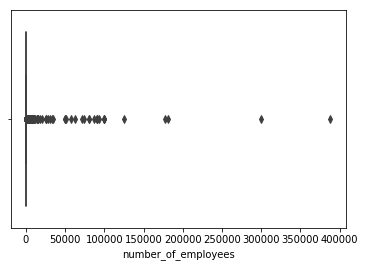

In [11]:
# looking for outliers first:
sns.boxplot(x=data['number_of_employees'])
# in this case we want a great ratio between big companies and start ups, it's preferible not to remove the big 4

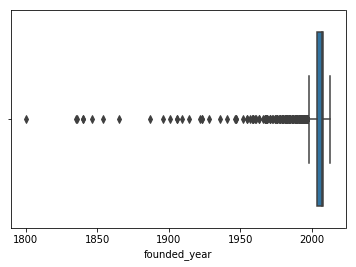

In [12]:
sns.boxplot(x=data['founded_year'])
# in this case we want to avoid old companies so it's recommended not to remove them from dataset

In [13]:
data_justforplot = data[(data['founded_year']>= data.founded_year.quantile(0.25)) & (data['number_of_employees']<=data.number_of_employees.quantile(0.75))]

Text(0.5, 0.98, 'Zoom on 75% companies - nb of employees')

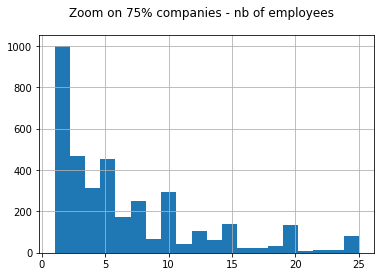

In [14]:
data_justforplot.number_of_employees.hist(bins=20)
plt.suptitle('Zoom on 75% companies - nb of employees')

Text(0.5, 0.98, 'Zoom on 75% companies - founded year')

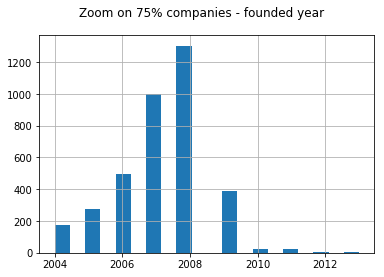

In [15]:
# First we have a look on these variables
data_justforplot.founded_year.hist(bins=20)
plt.suptitle('Zoom on 75% companies - founded year')

In [16]:
# creating a function to apply bins with Q1,Q2,Q3 and Q4 and be able to automate when refreshing database
def bins_q4(df,var):
    bins_labels = ['q1','q2','q3','q4']
    cutoffs = [cutoffs_tab[var]['min'],cutoffs_tab[var]['25%'],cutoffs_tab[var]['50%'],cutoffs_tab[var]['75%'],cutoffs_tab[var]['max']]
    return pd.cut(df[var],cutoffs, labels=bins_labels)

In [17]:
# we apply the bins to each var
data['founded_year_bins'] = bins_q4(data,'founded_year')
# and we check
data['founded_year_bins'].value_counts()

q2    2152
q1    1683
q3    1412
q4     479
Name: founded_year_bins, dtype: int64

In [18]:
# same for number of employees variable
data['number_of_employees_bins'] = bins_q4(data,'number_of_employees')
data['number_of_employees_bins'].value_counts()

q3    1394
q2    1371
q4    1367
q1    1114
Name: number_of_employees_bins, dtype: int64

In [19]:
data.category_code.value_counts()

web                 1408
software             959
other                414
advertising          395
games_video          394
mobile               296
ecommerce            282
consulting           272
enterprise           271
network_hosting      244
public_relations     222
search               186
hardware              78
security              40
analytics             34
cleantech             34
social                29
biotech               27
education             17
travel                15
finance               14
music                 13
semiconductor         13
news                  11
messaging              9
health                 8
photo_video            7
real_estate            7
legal                  5
fashion                4
hospitality            4
sports                 4
medical                2
nonprofit              2
design                 2
automotive             2
transportation         1
nanotech               1
manufacturing          1
Name: category_code, dtyp

In [20]:
# creating a function to apply a companies segmentation
def segmentation(category):
    tech = ['web', 'software', 'mobile', 'search']
    if category in tech:
        segment = 'tech'
    elif category == 'games_video':
        segment = 'gaming'
    else: 
        segment = 'others'
    return segment

In [21]:
# applying this function to the dataset so we can get the segmentation column:
data['segment'] = data['category_code'].apply(segmentation)

In [22]:
# checking
data.head()

,_id,category_code,description,founded_year,investments,ipo,name,number_of_employees,tag_list,founded_year_bins,number_of_employees_bins,segment
0,52cdef7c4bab8bd675297d8d,news,user driven social content website,2004,[],NaN,Digg,60,"community, social, news, bookmark, digg, techn...",q1,q4,others
1,52cdef7c4bab8bd675297d91,web,Geneology social network site,2006,[],NaN,Geni,18,"geni, geneology, social, family, genealogy",q2,q3,tech
2,52cdef7c4bab8bd675297d97,news,Read Unlimited Books,2007,[],NaN,Scribd,50,"book-subscription, digital-library, netflix-fo...",q2,q4,others
3,52cdef7c4bab8bd675297d94,social,Real time communication platform,2006,[],"{'valuation_amount': 18100000000, 'pub_year': ...",Twitter,1300,"text, messaging, social, community, twitter, t...",q2,q4,others
4,52cdef7c4bab8bd675297d8e,social,Social network,2004,"[{'funding_round': {'round_code': 'seed', 'fun...","{'valuation_amount': 104000000000, 'pub_year':...",Facebook,5299,"facebook, college, students, profiles, network...",q1,q4,others


In [23]:
# looking investments variables format
data.iloc[4]['investments']
# it's a list of dict of dicts as values --> we would need another query to apply JSON_normalize processing

[{'funding_round': {'round_code': 'seed', 'funded_year': 2009}},
 {'funding_round': {'round_code': 'grant', 'funded_year': 2008}},
 {'funding_round': {'round_code': 'seed', 'funded_year': 2013}}]

In [24]:
# looking ipo valuation variables format
data.iloc[4]['ipo']
# it's a dict with 2 keys:values

{'valuation_amount': 104000000000, 'pub_year': 2012}

In [25]:
# splitting ipo dict into pub_year and valuation_amount columns
valuations = data['ipo'].apply(pd.Series)
valuations.head()

,0,pub_year,valuation_amount
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,2013.0,1.810000e+10
4,NaN,2012.0,1.040000e+11


In [26]:
# then concatening the separate information to the original dataframe
data = pd.concat([data, valuations], axis=1).drop('ipo', axis = 1)
data.head()

,_id,category_code,description,founded_year,investments,name,number_of_employees,tag_list,founded_year_bins,number_of_employees_bins,segment,0,pub_year,valuation_amount
0,52cdef7c4bab8bd675297d8d,news,user driven social content website,2004,[],Digg,60,"community, social, news, bookmark, digg, techn...",q1,q4,others,NaN,NaN,NaN
1,52cdef7c4bab8bd675297d91,web,Geneology social network site,2006,[],Geni,18,"geni, geneology, social, family, genealogy",q2,q3,tech,NaN,NaN,NaN
2,52cdef7c4bab8bd675297d97,news,Read Unlimited Books,2007,[],Scribd,50,"book-subscription, digital-library, netflix-fo...",q2,q4,others,NaN,NaN,NaN
3,52cdef7c4bab8bd675297d94,social,Real time communication platform,2006,[],Twitter,1300,"text, messaging, social, community, twitter, t...",q2,q4,others,NaN,2013.0,1.810000e+10
4,52cdef7c4bab8bd675297d8e,social,Social network,2004,"[{'funding_round': {'round_code': 'seed', 'fun...",Facebook,5299,"facebook, college, students, profiles, network...",q1,q4,others,NaN,2012.0,1.040000e+11


In [27]:
# query to get the startups funding information per company and normalize JSON
query_investments = db.companies.find({'$and':[{'founded_year':{'$ne': None}},
                                    {'category_code':{'$ne': None}},
                                    {'deadpooled_year':None},
                                    {'number_of_employees':{'$gte':1}},
                                    {'offices.latitude':{'$ne':  None}},
                                    {'offices.longitude': {'$ne':  None}},
                                    {'offices.country_code':{'$ne':  None}},
                                    {'offices.city':{'$ne':  None}},
                                    {'investments.funding_round':{'$exists': True}}]},
                                    {'_id':1, 'name':1,
                                    'investments.funding_round.round_code':1,
                                    'investments.funding_round.funded_year':1})

In [28]:
# apply JSON normalize to investments query
investments = json_normalize(data=query_investments, 
                         record_path='investments', 
                         meta=['_id','name'], 
                         errors='ignore')

# checking funding_round variable type --> dict
investments.head()

,funding_round,_id,name
0,"{'round_code': 'seed', 'funded_year': 2009}",52cdef7c4bab8bd675297d8e,Facebook
1,"{'round_code': 'grant', 'funded_year': 2008}",52cdef7c4bab8bd675297d8e,Facebook
2,"{'round_code': 'seed', 'funded_year': 2013}",52cdef7c4bab8bd675297d8e,Facebook
3,"{'round_code': 'c', 'funded_year': 2007}",52cdef7c4bab8bd675297d9b,eBay
4,"{'round_code': 'a', 'funded_year': 2004}",52cdef7c4bab8bd675297d9b,eBay


In [29]:
# splitting this var dict into 2 separated columns through a new dataframe (founding_rounds)
founding_rounds = investments['funding_round'].apply(pd.Series)
# checking
founding_rounds.head()

,round_code,funded_year
0,seed,2009
1,grant,2008
2,seed,2013
3,c,2007
4,a,2004


In [30]:
# concatenating both columns to original investments dataframe
new_investments = pd.concat([investments, founding_rounds], axis=1)
# dropping the original funding_round dict column
new_investments = new_investments.drop('funding_round', axis = 1)

In [31]:
# just having a look on stages categories
new_investments.round_code.value_counts()

seed               408
unattributed        84
a                   80
b                   73
c                   62
d                   34
angel               23
e                    9
debt_round           6
f                    4
post_ipo_equity      4
grant                3
post_ipo_debt        2
partial              2
private_equity       1
convertible          1
Name: round_code, dtype: int64

In [32]:
# checking --> here we see that we can have several round stages per company
new_investments.head()

,_id,name,round_code,funded_year
0,52cdef7c4bab8bd675297d8e,Facebook,seed,2009
1,52cdef7c4bab8bd675297d8e,Facebook,grant,2008
2,52cdef7c4bab8bd675297d8e,Facebook,seed,2013
3,52cdef7c4bab8bd675297d9b,eBay,c,2007
4,52cdef7c4bab8bd675297d9b,eBay,a,2004


In [33]:
# checking how many funding rounds registers and unique companies
print(new_investments._id.nunique(),new_investments.shape)

80 (796, 4)


In [34]:
# getting only the last stage of foundings - to simplify
investments_last = new_investments.sort_values('funded_year').drop_duplicates(subset=['_id'], keep='last')
# checking it has been removed correctly, ie. for Facebook
investments_last.loc[investments_last['name']=='Facebook']

,_id,name,round_code,funded_year
2,52cdef7c4bab8bd675297d8e,Facebook,seed,2013


NOTE: We need to make sure that the approach for 'startups' definition not base this label assignement only on some  founding round stage (such as seed, angel, etc) but also on number of employees, so in this case Facebook can not be considered as a startup anymore. 

In [35]:
# checking number of employees of Facebook in 2013
data.loc[data['name']=='Facebook']

,_id,category_code,description,founded_year,investments,name,number_of_employees,tag_list,founded_year_bins,number_of_employees_bins,segment,0,pub_year,valuation_amount
4,52cdef7c4bab8bd675297d8e,social,Social network,2004,"[{'funding_round': {'round_code': 'seed', 'fun...",Facebook,5299,"facebook, college, students, profiles, network...",q1,q4,others,NaN,2012.0,1.040000e+11


In [36]:
# checking we only have one row per company - visually
investments_last.head()

,_id,name,round_code,funded_year
632,52cdef7d4bab8bd675299380,Zagat,b,2000
162,52cdef7c4bab8bd675297e96,AOL,b,2005
627,52cdef7d4bab8bd675298fc0,Nortel Networks,a,2007
674,52cdef7e4bab8bd67529ae11,Copan Systems,d,2007
650,52cdef7e4bab8bd67529aa87,ECI Telecom,c,2008


In [37]:
# checking we only have one row per company - for all
print(investments_last._id.nunique(),investments_last.shape)

80 (80, 4)


In [38]:
# merging our main data with investments data (dropping the investments dict column)
join_data = pd.merge(data,investments_last,left_on='_id',right_on='_id',how='left')
# checking
join_data.head()

,_id,category_code,description,founded_year,investments,name_x,number_of_employees,tag_list,founded_year_bins,number_of_employees_bins,segment,0,pub_year,valuation_amount,name_y,round_code,funded_year
0,52cdef7c4bab8bd675297d8d,news,user driven social content website,2004,[],Digg,60,"community, social, news, bookmark, digg, techn...",q1,q4,others,NaN,NaN,NaN,NaN,NaN,NaN
1,52cdef7c4bab8bd675297d91,web,Geneology social network site,2006,[],Geni,18,"geni, geneology, social, family, genealogy",q2,q3,tech,NaN,NaN,NaN,NaN,NaN,NaN
2,52cdef7c4bab8bd675297d97,news,Read Unlimited Books,2007,[],Scribd,50,"book-subscription, digital-library, netflix-fo...",q2,q4,others,NaN,NaN,NaN,NaN,NaN,NaN
3,52cdef7c4bab8bd675297d94,social,Real time communication platform,2006,[],Twitter,1300,"text, messaging, social, community, twitter, t...",q2,q4,others,NaN,2013.0,1.810000e+10,NaN,NaN,NaN
4,52cdef7c4bab8bd675297d8e,social,Social network,2004,"[{'funding_round': {'round_code': 'seed', 'fun...",Facebook,5299,"facebook, college, students, profiles, network...",q1,q4,others,NaN,2012.0,1.040000e+11,Facebook,seed,2013.0


In [39]:
join_data.columns
join_data = join_data[['_id','name_x','category_code',
           'founded_year','founded_year_bins',
           'number_of_employees','number_of_employees_bins','segment', 
           'pub_year','valuation_amount','round_code','funded_year',
           'tag_list','description']]
join_data.rename(columns={'name_x':'name'}, inplace=True)

In [40]:
# cleaning database
columns_nan = ['pub_year','valuation_amount','round_code','funded_year']
for col in columns_nan:
    join_data[col].fillna('', inplace=True)
join_data.head()

,_id,name,category_code,founded_year,founded_year_bins,number_of_employees,number_of_employees_bins,segment,pub_year,valuation_amount,round_code,funded_year,tag_list,description
0,52cdef7c4bab8bd675297d8d,Digg,news,2004,q1,60,q4,others,,,,,"community, social, news, bookmark, digg, techn...",user driven social content website
1,52cdef7c4bab8bd675297d91,Geni,web,2006,q2,18,q3,tech,,,,,"geni, geneology, social, family, genealogy",Geneology social network site
2,52cdef7c4bab8bd675297d97,Scribd,news,2007,q2,50,q4,others,,,,,"book-subscription, digital-library, netflix-fo...",Read Unlimited Books
3,52cdef7c4bab8bd675297d94,Twitter,social,2006,q2,1300,q4,others,2013,1.81e+10,,,"text, messaging, social, community, twitter, t...",Real time communication platform
4,52cdef7c4bab8bd675297d8e,Facebook,social,2004,q1,5299,q4,others,2012,1.04e+11,seed,2013,"facebook, college, students, profiles, network...",Social network


In [41]:
# defining if it's a small (startup) or a big company:
def type_comp(x):
    if x['valuation_amount'] != '':
        x['type'] = 'big company'
    elif x['number_of_employees'] >= 250:
        x['type'] = 'big company'
    elif (x['number_of_employees'] < 250) & (x['number_of_employees_bins'] == 'q4'):
        x['type'] = 'mid company'
    elif (x['number_of_employees_bins'] != 'q4') & (x['founded_year_bins'] == 'q4'):
        x['type'] = 'startup'
    elif (x['number_of_employees_bins'] != 'q4') & (x['founded_year_bins'] != 'q4'):
        x['type'] = 'small company'  
    else:
        x['type'] = 'others'
    return x['type']
    
# creating function to assign type
def get_type(df):
    df['type']= df.apply(lambda x: type_comp(x), axis=1)
    return df

# applying function to dataset to get the new column
join_data = get_type(join_data)

In [42]:
# checking
join_data.type.value_counts()

small company    3911
mid company      1121
startup           449
big company       246
Name: type, dtype: int64

### Normalizing Offices JSON

In [43]:
# query to get the offices information per company and normalize JSON
query_offices = db.companies.find({'$and':[{'founded_year':{'$ne': None}},
                                    {'category_code':{'$ne': None}},
                                    {'deadpooled_year':None},
                                    {'number_of_employees':{'$gte':1}},
                                    {'offices.latitude':{'$ne':  None}},
                                    {'offices.longitude': {'$ne':  None}},
                                    {'offices.country_code':{'$ne':  None}},
                                    {'offices.city':{'$ne':  None}}]},
                                    {'_id':1, 'name':1,
                                     'offices.latitude':1,'offices.longitude':1,
                                     'offices.country_code':1,'offices.city':1})

In [44]:
offices = json_normalize(data=query_offices, 
                         record_path='offices', 
                         meta=['_id','name'], 
                         errors='ignore')

# here we can check that we get all the offices per Company in rows
offices.head(10)

,city,country_code,latitude,longitude,_id,name
0,San Francisco,USA,37.764726,-122.394523,52cdef7c4bab8bd675297d8d,Digg
1,West Hollywood,USA,34.090368,-118.393064,52cdef7c4bab8bd675297d91,Geni
2,San Francisco,USA,37.789634,-122.404052,52cdef7c4bab8bd675297d97,Scribd
3,San Francisco,USA,37.776805,-122.416924,52cdef7c4bab8bd675297d94,Twitter
4,Menlo Park,USA,37.416050,-122.151801,52cdef7c4bab8bd675297d8e,Facebook
5,Dublin,IRL,53.344104,-6.267494,52cdef7c4bab8bd675297d8e,Facebook
6,New York,USA,40.755716,-73.979247,52cdef7c4bab8bd675297d8e,Facebook
7,Sunnyvale,USA,37.387845,-122.055197,52cdef7c4bab8bd675297da1,Plaxo
8,New York City,USA,40.757929,-73.985506,52cdef7c4bab8bd675297d9c,MeetMoi
9,San Jose,USA,37.295005,-121.930035,52cdef7c4bab8bd675297d9b,eBay


In [45]:
# creating function to get geopoint
def get_geopoint(df):
    df['geopoint']= df.apply(lambda x: [x['longitude'], x['latitude']], axis=1)
    return df

# applying function to offices dataframe to get a new column with geopoint
offices_geopoint = get_geopoint(offices)

# checking
offices_geopoint.head()

,city,country_code,latitude,longitude,_id,name,geopoint
0,San Francisco,USA,37.764726,-122.394523,52cdef7c4bab8bd675297d8d,Digg,"[-122.394523, 37.764726]"
1,West Hollywood,USA,34.090368,-118.393064,52cdef7c4bab8bd675297d91,Geni,"[-118.393064, 34.090368]"
2,San Francisco,USA,37.789634,-122.404052,52cdef7c4bab8bd675297d97,Scribd,"[-122.404052, 37.789634]"
3,San Francisco,USA,37.776805,-122.416924,52cdef7c4bab8bd675297d94,Twitter,"[-122.4169244, 37.7768052]"
4,Menlo Park,USA,37.416050,-122.151801,52cdef7c4bab8bd675297d8e,Facebook,"[-122.151801, 37.41605]"


In [46]:
# creating function to get geoquery
def get_geoquery(df):
    df['geoquery'] = df.apply(lambda x: {'type':'Point','coords':x['geopoint']}, axis=1)
    return df

# applying function to offices dataframe to get a new column with geopoint
offices_geoquery = get_geoquery(offices_geopoint)

# checking
offices_geoquery.head()

,city,country_code,latitude,longitude,_id,name,geopoint,geoquery
0,San Francisco,USA,37.764726,-122.394523,52cdef7c4bab8bd675297d8d,Digg,"[-122.394523, 37.764726]","{'type': 'Point', 'coords': [-122.394523, 37.7..."
1,West Hollywood,USA,34.090368,-118.393064,52cdef7c4bab8bd675297d91,Geni,"[-118.393064, 34.090368]","{'type': 'Point', 'coords': [-118.393064, 34.0..."
2,San Francisco,USA,37.789634,-122.404052,52cdef7c4bab8bd675297d97,Scribd,"[-122.404052, 37.789634]","{'type': 'Point', 'coords': [-122.404052, 37.7..."
3,San Francisco,USA,37.776805,-122.416924,52cdef7c4bab8bd675297d94,Twitter,"[-122.4169244, 37.7768052]","{'type': 'Point', 'coords': [-122.4169244, 37...."
4,Menlo Park,USA,37.416050,-122.151801,52cdef7c4bab8bd675297d8e,Facebook,"[-122.151801, 37.41605]","{'type': 'Point', 'coords': [-122.151801, 37.4..."


In [47]:
# merging our main data (all companies info with investments rounds and valuations, with offices details)
total_data = pd.merge(offices,join_data,left_on='_id',right_on='_id',how='left')
total_data.head(20)

,city,country_code,latitude,longitude,_id,name_x,geopoint,geoquery,name_y,category_code,...,number_of_employees,number_of_employees_bins,segment,pub_year,valuation_amount,round_code,funded_year,tag_list,description,type
0,San Francisco,USA,37.764726,-122.394523,52cdef7c4bab8bd675297d8d,Digg,"[-122.394523, 37.764726]","{'type': 'Point', 'coords': [-122.394523, 37.7...",Digg,news,...,60,q4,others,,,,,"community, social, news, bookmark, digg, techn...",user driven social content website,mid company
1,West Hollywood,USA,34.090368,-118.393064,52cdef7c4bab8bd675297d91,Geni,"[-118.393064, 34.090368]","{'type': 'Point', 'coords': [-118.393064, 34.0...",Geni,web,...,18,q3,tech,,,,,"geni, geneology, social, family, genealogy",Geneology social network site,small company
2,San Francisco,USA,37.789634,-122.404052,52cdef7c4bab8bd675297d97,Scribd,"[-122.404052, 37.789634]","{'type': 'Point', 'coords': [-122.404052, 37.7...",Scribd,news,...,50,q4,others,,,,,"book-subscription, digital-library, netflix-fo...",Read Unlimited Books,mid company
3,San Francisco,USA,37.776805,-122.416924,52cdef7c4bab8bd675297d94,Twitter,"[-122.4169244, 37.7768052]","{'type': 'Point', 'coords': [-122.4169244, 37....",Twitter,social,...,1300,q4,others,2013,1.81e+10,,,"text, messaging, social, community, twitter, t...",Real time communication platform,big company
4,Menlo Park,USA,37.416050,-122.151801,52cdef7c4bab8bd675297d8e,Facebook,"[-122.151801, 37.41605]","{'type': 'Point', 'coords': [-122.151801, 37.4...",Facebook,social,...,5299,q4,others,2012,1.04e+11,seed,2013,"facebook, college, students, profiles, network...",Social network,big company
5,Dublin,IRL,53.344104,-6.267494,52cdef7c4bab8bd675297d8e,Facebook,"[-6.267494, 53.344104]","{'type': 'Point', 'coords': [-6.267494, 53.344...",Facebook,social,...,5299,q4,others,2012,1.04e+11,seed,2013,"facebook, college, students, profiles, network...",Social network,big company
6,New York,USA,40.755716,-73.979247,52cdef7c4bab8bd675297d8e,Facebook,"[-73.9792469, 40.7557162]","{'type': 'Point', 'coords': [-73.9792469, 40.7...",Facebook,social,...,5299,q4,others,2012,1.04e+11,seed,2013,"facebook, college, students, profiles, network...",Social network,big company
7,Sunnyvale,USA,37.387845,-122.055197,52cdef7c4bab8bd675297da1,Plaxo,"[-122.055197, 37.387845]","{'type': 'Point', 'coords': [-122.055197, 37.3...",Plaxo,web,...,50,q4,tech,,,,,"contact-management, address-book, sync, contac...",Contact Management,mid company
8,New York City,USA,40.757929,-73.985506,52cdef7c4bab8bd675297d9c,MeetMoi,"[-73.985506, 40.757929]","{'type': 'Point', 'coords': [-73.985506, 40.75...",MeetMoi,social,...,15,q3,others,,,,,"mobile, dating, location, realtime, phone",Mobile Dating,small company
9,San Jose,USA,37.295005,-121.930035,52cdef7c4bab8bd675297d9b,eBay,"[-121.930035, 37.295005]","{'type': 'Point', 'coords': [-121.930035, 37.2...",eBay,web,...,15000,q4,tech,1998,,d,2013,"auction, bid, search, market",Online Marketplace,big company


In [48]:
total_data.drop('name_y',axis=1, inplace=True)
total_data.rename(columns={'name_x':'name'}, inplace=True)
total_data.head()

,city,country_code,latitude,longitude,_id,name,geopoint,geoquery,category_code,founded_year,...,number_of_employees,number_of_employees_bins,segment,pub_year,valuation_amount,round_code,funded_year,tag_list,description,type
0,San Francisco,USA,37.764726,-122.394523,52cdef7c4bab8bd675297d8d,Digg,"[-122.394523, 37.764726]","{'type': 'Point', 'coords': [-122.394523, 37.7...",news,2004,...,60,q4,others,,,,,"community, social, news, bookmark, digg, techn...",user driven social content website,mid company
1,West Hollywood,USA,34.090368,-118.393064,52cdef7c4bab8bd675297d91,Geni,"[-118.393064, 34.090368]","{'type': 'Point', 'coords': [-118.393064, 34.0...",web,2006,...,18,q3,tech,,,,,"geni, geneology, social, family, genealogy",Geneology social network site,small company
2,San Francisco,USA,37.789634,-122.404052,52cdef7c4bab8bd675297d97,Scribd,"[-122.404052, 37.789634]","{'type': 'Point', 'coords': [-122.404052, 37.7...",news,2007,...,50,q4,others,,,,,"book-subscription, digital-library, netflix-fo...",Read Unlimited Books,mid company
3,San Francisco,USA,37.776805,-122.416924,52cdef7c4bab8bd675297d94,Twitter,"[-122.4169244, 37.7768052]","{'type': 'Point', 'coords': [-122.4169244, 37....",social,2006,...,1300,q4,others,2013,1.81e+10,,,"text, messaging, social, community, twitter, t...",Real time communication platform,big company
4,Menlo Park,USA,37.416050,-122.151801,52cdef7c4bab8bd675297d8e,Facebook,"[-122.151801, 37.41605]","{'type': 'Point', 'coords': [-122.151801, 37.4...",social,2004,...,5299,q4,others,2012,1.04e+11,seed,2013,"facebook, college, students, profiles, network...",Social network,big company


In [49]:
companies_per_country = total_data.groupby('country_code')['country_code'].count()
companies_per_country = companies_per_country.sort_values(ascending=False)
top20countries = companies_per_country.head(20)
display(top20countries)

country_code
USA    3298
GBR     314
CAN     240
FRA     125
DEU     124
IND     111
AUS      86
ESP      77
NLD      72
ITA      45
BEL      42
SWE      38
IRL      32
CHE      24
SGP      21
FIN      19
ARG      17
PRT      16
BRA      16
NZL      16
Name: country_code, dtype: int64

In [50]:
top20countries['BRA']

16

In [51]:
top20countries.index

Index(['USA', 'GBR', 'CAN', 'FRA', 'DEU', 'IND', 'AUS', 'ESP', 'NLD', 'ITA',
       'BEL', 'SWE', 'IRL', 'CHE', 'SGP', 'FIN', 'ARG', 'PRT', 'BRA', 'NZL'],
      dtype='object', name='country_code')

In [52]:
# filtering total data set to top 20 countries
data_top20 = total_data[total_data.country_code.isin(list(top20countries.index))]
# checking we only have those top 20 countries
data_top20.country_code.nunique()

20

In [53]:
type_per_country = pd.DataFrame(pd.pivot_table(data_top20, 
                       index=['country_code'], 
                       columns=['type'], 
                       values=['_id'],
                       dropna=True,
                       aggfunc= len,
                       margins=True,
                       fill_value=0))

In [54]:
type_per_country.head()

_id                                       
type         big company mid company small company startup  All
country_code                                                   
ARG                    0           6            10       1   17
AUS                    1          14            68       3   86
BEL                    0           5            34       3   42
BRA                    2           4             8       2   16
CAN                   10          49           173       8  240

In [55]:
# type_per_country['big_medium'] = (type_per_country['big company']+ type_per_country['mid company'])/ type_per_country['All']
# type_per_country['startups'] = type_per_country['startup']/ type_per_country['All']            

In [56]:
segment_per_country = pd.DataFrame(pd.pivot_table(data_top20, 
                       index=['country_code'], 
                       columns=['segment'], 
                       values=['_id'],
                       dropna=True,
                       aggfunc= len,
                       margins=True,
                       fill_value=0))

In [57]:
display(segment_per_country)

_id                   
segment      gaming others  tech   All
country_code                          
ARG               1      6    10    17
AUS               6     22    58    86
BEL               0     20    22    42
BRA               1      8     7    16
CAN              11    109   120   240
CHE               2     11    11    24
DEU              12     50    62   124
ESP               4     32    41    77
FIN               2      3    14    19
FRA              14     43    68   125
GBR              20    139   155   314
IND               5     54    52   111
IRL               2     19    11    32
ITA               3     24    18    45
NLD               3     26    43    72
NZL               0      4    12    16
PRT               1      5    10    16
SGP               1     10    10    21
SWE               1     15    22    38
USA             193   1577  1528  3298
All             282   2177  2274  4733

In [58]:
seniority_per_country = pd.DataFrame(pd.pivot_table(data_top20, 
                       index=['country_code'], 
                       columns=['founded_year_bins'], 
                       values=['_id'],
                       dropna=True,
                       aggfunc= len,
                       margins=True,
                       fill_value=0))

In [59]:
display(seniority_per_country)

_id                      
founded_year_bins    q1    q2   q3   q4   All
country_code                                 
ARG                   5    10    1    1    17
AUS                  29    40   14    3    86
BEL                  16    12   11    3    42
BRA                   6     6    1    3    16
CAN                  92    81   58    9   240
CHE                   6    10    7    1    24
DEU                  25    61   27   11   124
ESP                  26    30   13    8    77
FIN                   7     4    5    3    19
FRA                  33    53   33    6   125
GBR                  94   123   74   23   314
IND                  35    39   32    5   111
IRL                  10    15    7    0    32
ITA                  13    23    8    1    45
NLD                  19    30   18    5    72
NZL                   5     5    5    0    15
PRT                   1     8    5    2    16
SGP                   3     9    7    2    21
SWE                  14    17    4    3    38
USA                1225  1262  645  166  3298
All                1664  1838  975  255  4732

In [60]:
# def attractive(x):
#     return (x(_id, gaming) + x(_id,tech)) / (x(_id,All) * 100)
# segment_per_country['attractive gaming tech'] = segment_per_country.apply(lambda x: attractive(x))

In [62]:
total_data.head()

,city,country_code,latitude,longitude,_id,name,geopoint,geoquery,category_code,founded_year,...,number_of_employees,number_of_employees_bins,segment,pub_year,valuation_amount,round_code,funded_year,tag_list,description,type
0,San Francisco,USA,37.764726,-122.394523,52cdef7c4bab8bd675297d8d,Digg,"[-122.394523, 37.764726]","{'type': 'Point', 'coords': [-122.394523, 37.7...",news,2004,...,60,q4,others,,,,,"community, social, news, bookmark, digg, techn...",user driven social content website,mid company
1,West Hollywood,USA,34.090368,-118.393064,52cdef7c4bab8bd675297d91,Geni,"[-118.393064, 34.090368]","{'type': 'Point', 'coords': [-118.393064, 34.0...",web,2006,...,18,q3,tech,,,,,"geni, geneology, social, family, genealogy",Geneology social network site,small company
2,San Francisco,USA,37.789634,-122.404052,52cdef7c4bab8bd675297d97,Scribd,"[-122.404052, 37.789634]","{'type': 'Point', 'coords': [-122.404052, 37.7...",news,2007,...,50,q4,others,,,,,"book-subscription, digital-library, netflix-fo...",Read Unlimited Books,mid company
3,San Francisco,USA,37.776805,-122.416924,52cdef7c4bab8bd675297d94,Twitter,"[-122.4169244, 37.7768052]","{'type': 'Point', 'coords': [-122.4169244, 37....",social,2006,...,1300,q4,others,2013,1.81e+10,,,"text, messaging, social, community, twitter, t...",Real time communication platform,big company
4,Menlo Park,USA,37.416050,-122.151801,52cdef7c4bab8bd675297d8e,Facebook,"[-122.151801, 37.41605]","{'type': 'Point', 'coords': [-122.151801, 37.4...",social,2004,...,5299,q4,others,2012,1.04e+11,seed,2013,"facebook, college, students, profiles, network...",Social network,big company


In [75]:
total_data.to_json('companies_segmentation.json', orient='records', lines=True)
#total_data.to_json('companies_segmentation.json', orient='records', lines=True, default_handler=str)

OverflowError: Overlong 2 byte UTF-8 sequence detected when encoding string

Duda: me daba ese error si no ponía default_handler = str

In [64]:
# connecting on default host and port
client = MongoClient ('localhost', 27017)

# loading the database
db = client['companies_segmentation']

# getting the collection
companies_segmentation = db['companies_segmentation']

In [ ]:
# # creating index for geoqueries
# companies_segmentation.create_index([('geoquery', GEOSPHERE)])

In [65]:
# defining the 'near' geoquery function to get the closest offices with the parameters
# max distance for search_area is in meters
    
def near_geoquery(long, lat, search_area):
  
    ref_point = {"long_ref": long,"lat_ref": lat}
    busqueda = companies_segmentation.find({"geoquery":{"$near":{"$geometry": 
                {"type":"Point" ,
                "coords": [ref_point["long_ref"] , ref_point["lat_ref"]]},
                "$maxDistance": search_area}}},                    
                {'latitude': 1,'longitude': 1,
                'city': 1,'country_code': 1,
                '_id': 1,'name': 1,
                'category_code':1,'type': 1,'segment': 1,
                'founded_year':1,'founded_year_bins':1,
                'number_of_employees': 1,'number_of_employees_bins': 1})
    return cursor

In [72]:
for doc in len(companies_segmentation.geopoint):
    search_area=10000
    near_geoquery(doc['longitude'], doc['latitude'], search_area)

TypeError: object of type 'Collection' has no len()

In [68]:
# geoquery = pd.DataFrame(near_geoquery())
# geoquery.head()

ValueError: DataFrame constructor not properly called!